In [1]:
from qiskit import *
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.stats import rv_continuous
from qiskit.circuit import Parameter, ParameterVector

In [2]:
def unitary(circ,eta,phi,t):
    theta = np.arccos(-eta);
    circ.u3(theta,phi,t,0);

In [3]:
class PQC:
    def __init__(self,name,layer):
        self.backend = Aer.get_backend('statevector_simulator');
        self.circ = QuantumCircuit(layer);
        self.name = name;
        self.seed = 14256;
        self.layer = layer;
        np.random.seed(self.seed);
        if self.name == "rcz":
            self.theta = Parameter('θ');
            for index in range(layer):
                self.circ.h(index);
            c = QuantumCircuit(1,name="Rz");
            c.rz(self.theta,0);
            temp = c.to_gate().control(1);
            self.circ.append(temp,[0,1]);
        if self.name == "circ4":
            self.theta1 = ParameterVector('θ1', layer);
            self.theta2 = ParameterVector('θ2', layer);
            self.theta3 = ParameterVector('θ3', layer-1);
            # print(self.theta1)
            for i in range(self.layer):
                self.circ.rx(self.theta1[i],i);
            for i in range(self.layer):
                self.circ.rz(self.theta2[i],i);
            for i in range(self.layer-1):
                c = QuantumCircuit(1, name="Rx");
                c.rz(self.theta3[i],0);
                temp = c.to_gate().control(1);
                self.circ.append(temp,[i,i+1]);

    def get(self):
        if self.name == "rcz":
            t = np.random.uniform(0,2*np.pi);
            # theta = Parameter('θ');
            self.circ1 = self.circ.assign_parameters({self.theta:t});
            result = execute(self.circ1,self.backend).result();
            out_state = result.get_statevector();
            self.statevector = np.asmatrix(out_state).T;
            return self.statevector;
        if self.name == "circ4":
            self.circ1 = self.circ.bind_parameters({self.theta1: np.random.uniform(0,2*np.pi,self.layer)});
            self.circ2 = self.circ1.bind_parameters({self.theta2: np.random.uniform(0,2*np.pi,self.layer)});
            self.circ3 = self.circ2.bind_parameters({self.theta3: np.random.uniform(0,2*np.pi,self.layer-1)});
            result = execute(self.circ3,self.backend).result();
            out_state = result.get_statevector();
            self.statevector = np.asmatrix(out_state).T;
            return self.statevector;

    def draw(self):
        self.circ.draw('mpl');
        print(self.circ);

In [4]:
pqc = PQC("rcz",2);

In [5]:
pqc.draw()

     ┌───┐         
q_0: ┤ H ├────■────
     ├───┤┌───┴───┐
q_1: ┤ H ├┤ Rz(θ) ├
     └───┘└───────┘


In [6]:
def Haar(F,N):
    if F<0 or F>1:
        return 0;
    return (N-1)*(1-F)**(N-2);
def kl_divergence(p, q):
    return np.sum(np.where(p*q != 0, p * np.log(p / q), 0));
class Haar_dist(rv_continuous):
    def _pdf(self,x,n):
        return Haar(x,n*2);
def I(b,j,n,vec):
    newvec = np.zeros((2**(n-1),1));
    for new_index in range(2**(n-1)):
        original_index = new_index%(2**(n-j)) + (new_index//(2**(n-j)))*(2**(n-j+1)) + b*(2**(n-j));
        # print(original_index);
        newvec[new_index]=vec[int(original_index)];
    return newvec;
def D(u,v,m):
    dist = 0;
    for i in range(m):
        for j in range(m):
            a = u[i]*v[j]-u[j]*v[i];
            print(np.abs(a))
            dist += (1/2)*np.abs(a)**2;
    print(u,", ",v," -> ",dist,"\n")
    return dist;
def Q(n,vec):
    sum = 0;
    for j in range(n):
        sum += D(I(0,j+1,n,vec),I(1,j+1,n,vec),2**(n-1));
    return (sum * 4 / n)[0];

In [7]:
def expressibility(pqc, reps):
    arr = [];
    for i in range(reps):
        fid = np.abs(pqc.get().getH()*pqc.get())**2;
        arr.append(fid[0,0]);
        if i%100==0 and i!=0:
            print(i,"\n");
    haar = [];
    h = Haar_dist(a=0,b=1,name="haar");
    for i in range(reps):
        haar.append(h.ppf((i+0.5)/reps,pqc.layer));
    n_bins = 100;
    haar_pdf = plt.hist(np.array(haar), bins=n_bins, alpha=0.5)[0]/reps; 
    pqc_pdf = plt.hist(np.array(arr), bins=n_bins, alpha=0.5)[0]/reps;
    kl = kl_divergence(pqc_pdf,haar_pdf);
    plt.title('KL(P||Q) = %1.4f' % kl)
    return kl;
def entangling_capability(pqc, reps):
    sum = 0;
    print(pqc.layer);
    for i in range(reps):
        sum += Q(pqc.layer,pqc.get());
        # print(Q(pqc.layer,pqc.get()))
        if i%100==0 and i!=0:
            print(i,"\n");
    return sum/reps;

100 

200 

300 

400 

500 

600 

700 

800 

900 

0.7521884070424627


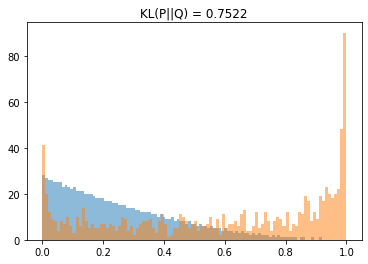

In [8]:
print(expressibility(pqc, 1000))

In [9]:
print(entangling_capability(pqc,1000))

e-17]
[0.]
[[0.5]
 [0.5]] ,  [[0.48739348]
 [0.48739348]]  ->  [3.08148791e-33] 

[0.]
[3.46944695e-18]
[3.46944695e-18]
[0.]
[[ 0.5       ]
 [-0.02161777]] ,  [[ 0.5       ]
 [-0.02161777]]  ->  [1.20370622e-35] 

[0.]
[3.46944695e-18]
[3.46944695e-18]
[0.]
[[0.5]
 [0.5]] ,  [[-0.02161777]
 [-0.02161777]]  ->  [1.20370622e-35] 

[0.]
[5.55111512e-17]
[5.55111512e-17]
[0.]
[[0.5       ]
 [0.48372032]] ,  [[0.5       ]
 [0.48372032]]  ->  [3.08148791e-33] 

[0.]
[5.55111512e-17]
[5.55111512e-17]
[0.]
[[0.5]
 [0.5]] ,  [[0.48372032]
 [0.48372032]]  ->  [3.08148791e-33] 

[0.]
[0.]
[0.]
[0.]
[[0.5       ]
 [0.45663023]] ,  [[0.5       ]
 [0.45663023]]  ->  [0.] 

[0.]
[0.]
[0.]
[0.]
[[0.5]
 [0.5]] ,  [[0.45663023]
 [0.45663023]]  ->  [0.] 

[0.]
[5.55111512e-17]
[5.55111512e-17]
[0.]
[[0.5       ]
 [0.46801907]] ,  [[0.5       ]
 [0.46801907]]  ->  [3.08148791e-33] 

[0.]
[5.55111512e-17]
[5.55111512e-17]
[0.]
[[0.5]
 [0.5]] ,  [[0.46801907]
 [0.46801907]]  ->  [3.08148791e-33] 

[0.]
[0.